# Version Control
* Version 6: Pre-labelling all training data with KMeans
* Version 7: KShape modelling and pre-labelling all training data
* Version 8: Kmeans; centering + normalization; pre-labelling train set

# Configuration

In [1]:
# random state and folds
SEED = 1111
NFOLD = 5

# feature engineering options
N_STOCK = 112
MIN_MAX_SCALING = True
REDUCE_MEMORY = True
TRAIN_TEST = 'train'

In [2]:
# example of simple DataFrame
# df = pd.DataFrame({'a':[1,2,3,4], 'b':[6,7,np.NaN,9]})
# df = pd.DataFrame({'a':[1,2,3,4], 'b':[6,7,np.NaN,9], 'c':['x','x','y','y']})

In [3]:
import os
import sys
import pickle
import psutil
import warnings
import re
import gc
import datetime

from scipy.stats import pearsonr
import numpy as np
import pandas as pd
from numba import njit
from multiprocessing import Pool
# import cupy as np
# import cudf as pd
# import cuml

from plotnine import ggplot, aes, geom_line, geom_point
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
import lightgbm as lgbm

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [4]:
# general helper functions

def load_target(train_test):
    file_name = f'/kaggle/input/optiver-realized-volatility-prediction/{train_test}.csv'
    return pd.read_csv(file_name)

def load_single_stock(stock_id, train_test, book_trade):
    path = f'/kaggle/input/optiver-realized-volatility-prediction/{book_trade}_{train_test}.parquet/stock_id={str(stock_id)}'
    filename = os.path.join(path, os.listdir(path)[0])
    return pd.read_parquet(filename)

def format_agg_cols(x, time_start, time_end):
    if x[0]=='time_id':
        return x[0]
    else:
        col = '_'.join(x).replace('arr_nb_','')
        return f'{col}_{time_start:03}-{time_end:03}'
    
def vol(s):
    return np.sqrt(np.sum(np.square(s)))

def n_unique(s):
    return len(set(s))

def frame_to_list(df):
    lst = []
    for col in df.columns:
        lst.append((col, df[col].values.astype(np.float32)))
    return lst

def list_to_frame(lst):
    return pd.DataFrame(dict(lst))

def save_pickle(obj, filename):
    file = open(filename, 'wb')
    pickle.dump(obj, file)
    file.close()
    
def report_mem_usage():
    print(f'Memory used: {psutil.virtual_memory().percent:}%')

In [5]:
# function to standardize certain features
def standardize_features(data, target_cols):
    scaler = StandardScaler()
    transformed_data = pd.DataFrame(scaler.fit_transform(data[target_cols]), columns=target_cols)
    data = pd.concat([data[[col for col in data.columns if col not in target_cols]], transformed_data], axis=1)
    return data

# Time Series Clustering

In [6]:
!pip install ../input/tslearn052/tslearn-0.5.2-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl
from tslearn.clustering import TimeSeriesKMeans, KShape
from tslearn.generators import random_walks
from tslearn.utils import to_time_series_dataset
from tslearn.barycenters import dtw_barycenter_averaging
import math
import random

Processing /kaggle/input/tslearn052/tslearn-0.5.2-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl


In [7]:
def preprocess_single_stock(stock_id, n_time_id_sample, seconds_sample_interval, remove_first_n_seconds, delete_unused_cols):
    # load data
    book = load_single_stock(stock_id, 'train', 'book')
    # ffill and bfill
    time_id_list =  pd.DataFrame({'time_id':book.time_id.unique().tolist()})
    seconds_in_bucket_list = pd.DataFrame({'seconds_in_bucket':range(600)})
    base = time_id_list.merge(seconds_in_bucket_list, how='cross')
    book = base.merge(book, how='left', on=['time_id','seconds_in_bucket'])
    book = book.ffill().bfill()
    # sampling time_id
    time_id_samples = random.sample(book['time_id'].unique().tolist(), n_time_id_sample)
    book = book[book.time_id.isin(time_id_samples)]
    # create time series
    book['wap1'] = (book['bid_price1'] * book['ask_size1'] + book['ask_price1'] * book['bid_size1']) / ( book['bid_size1'] +  book['ask_size1'])
    book['wap1_sma50'] = book.groupby('time_id')['wap1'].apply(lambda s: s.rolling(window=50).mean())
    book['wap1_lr'] = np.log(book['wap1']).diff()
    book['wap1_sms50'] = book.groupby('time_id')['wap1_lr'].apply(lambda s: s.rolling(window=50).std())
    book['total_volume'] = book['ask_size1'] + book['ask_size2'] + book['bid_size1'] + book['bid_size2']
    book['total_volume'] = (book['total_volume'] - book['total_volume'].mean()) / book['total_volume'].std()
    book['total_volume_sma60'] = book.groupby('time_id')['total_volume'].apply(lambda s: s.rolling(window=60).mean())
    book['volume_imbalance'] = (book['ask_size1'] + book['ask_size2']) - (book['bid_size1'] + book['bid_size2'])
    book['volume_imbalance'] = (book['volume_imbalance'] - book['volume_imbalance'].mean()) / book['volume_imbalance'].std()
    book['volume_imbalance_sma80'] = book.groupby('time_id')['volume_imbalance'].apply(lambda s: s.rolling(window=80).mean())
    # remove first few entries to avoid NA
    book = book[book.seconds_in_bucket >= remove_first_n_seconds].reset_index(drop=True)
    # normalization
    book['wap1_sma50'] = (book['wap1_sma50'] - book['wap1_sma50'].mean()) / book['wap1_sma50'].std()
    book['wap1_sms50'] = (book['wap1_sms50'] - book['wap1_sms50'].mean()) / book['wap1_sms50'].std()
    book['total_volume_sma60'] = (book['total_volume_sma60'] - book['total_volume_sma60'].mean()) / book['total_volume_sma60'].std()
    book['volume_imbalance_sma80'] = (book['volume_imbalance_sma80'] - book['volume_imbalance_sma80'].mean()) / book['volume_imbalance_sma80'].std()
    # centering
    book['wap1_sma50'] = book['wap1_sma50'] - book['wap1_sma50'].median()
    book['wap1_sms50'] = book['wap1_sms50'] - book['wap1_sms50'].median()
    book['total_volume_sma60'] = book['total_volume_sma60'] - book['total_volume_sma60'].median()
    book['volume_imbalance_sma80'] = book['volume_imbalance_sma80'] - book['volume_imbalance_sma80'].median()
    # seconds interval filtering
    idx = book.index.tolist()[::seconds_sample_interval]
    book = book.iloc[idx,:]
    # select only relevant columns
    book['stock_id'] = stock_id
    if delete_unused_cols==True:
        book = book[['stock_id','time_id','seconds_in_bucket','wap1_sma50','wap1_sms50','total_volume_sma60','volume_imbalance_sma80']]
    return book

def preprocess_all_stocks(n_stock):
    stock_list = sorted([int(x.split('=')[1]) for x in os.listdir(f'/kaggle/input/optiver-realized-volatility-prediction/book_train.parquet')])[:n_stock]
    data = []
    for stock_id in stock_list:
        df = preprocess_single_stock(stock_id=stock_id, n_time_id_sample=100, seconds_sample_interval=10, remove_first_n_seconds=10, delete_unused_cols=True)
        data.append(df)
    data = pd.concat(data, axis=0).reset_index(drop=True)
    return data

def dataframe_to_ts(data, series):
    ts = [data[(data.stock_id==stock_id) & (data.time_id==time_id) & (data[series].isnull()==False)][series].tolist() for stock_id, time_id in book[['stock_id','time_id']].drop_duplicates().to_records(index=False).tolist()]
    ts = to_time_series_dataset(ts)
    return ts

def visualize_smoothing_and_downsampling(data, series, smoothing_method, smoothing_param, rolling_stat, intervals):
    # setting parameters
    time_id = random.choice(data.time_id.unique().tolist())
    n_smoothing_param, n_intervals = len(smoothing_param), len(intervals)
    series_names = [series]
    # building EWM series
    for p in smoothing_param:
        if smoothing_method=='ewm' and rolling_stat=='mean':
            data[f'{series}_ewma{int(p*100):03}'] = data.groupby('time_id')[series].apply(lambda s: s.ewm(com=p).mean())
            series_names.append(f'{series}_ewma{int(p*100):03}')
        elif smoothing_method=='ewm' and rolling_stat=='std':
            data[f'{series}_ewms{int(p*100):03}'] = data.groupby('time_id')[series].apply(lambda s: s.ewm(com=p).std())
            series_names.append(f'{series}_ewms{int(p*100):03}')
        elif smoothing_method=='sm' and rolling_stat=='mean':
            data[f'{series}_sma{int(p)}'] = data.groupby('time_id')[series].apply(lambda s: s.rolling(window=p).mean())
            series_names.append(f'{series}_sma{int(p)}')
        elif smoothing_method=='sm' and rolling_stat=='std':
            data[f'{series}_sms{int(p)}'] = data.groupby('time_id')[series].apply(lambda s: s.rolling(window=p).std())
            series_names.append(f'{series}_sms{int(p)}')
    # collect all series to be plotted in a list
    ts_collection = []
    for name in series_names:
        ts_collection += [data[data.time_id==time_id][name].tolist()[::i] for i in intervals]
    # plotting
    r, c = 0, 0
    fig, axs = plt.subplots(n_smoothing_param+1, n_intervals, figsize=(30, 12))
    for s in ts_collection:
        axs[r, c].plot(s)
        c += 1
        if c%n_intervals == 0:
            r, c = r + 1, 0
    return

def plot_cluster_distribution(model):
    cluster_count = model.cluster_centers_.shape[0]
    labels = model.labels_
    cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
    cluster_n = [f'Cluster {i}' for i in range(cluster_count)]
    plt.figure(figsize=(15,5))
    plt.title("Cluster Distribution for KMeans")
    plt.bar(cluster_n,cluster_c)
    plt.show()
    
def visualize_patterns(model, data, n_sample_ts):
    labels = model.predict(data)
    labels = pd.DataFrame(list(enumerate(labels)), columns=['id','label'])
    n_cluster = len(labels.label.unique().tolist())
    nrow, ncol = math.ceil(n_cluster/5), min(5, n_cluster)
    fig, axs = plt.subplots(nrow, ncol, figsize=(40,5))
    r, c = 0, 0
    for label in sorted(labels.label.unique().tolist()):
        cluster = []
        ids = labels[labels.label==label]['id'].tolist()
        ids = [s for s in ids if s in random.sample(ids, min(n_sample_ts, len(ids)))]
        for i in ids:
            if nrow==1:
                axs[c].plot(data[i],c="gray",alpha=0.4)
            else:
                axs[r, c].plot(data[i],c="gray",alpha=0.4)
            cluster.append(data[i].reshape(-1))
        if len(cluster) > 0:
            if nrow==1:
                axs[c].plot(dtw_barycenter_averaging(np.array(cluster)), c="red")
            else:
                axs[r, c].plot(dtw_barycenter_averaging(np.array(cluster)), c="red")
        if nrow==1:
            axs[c].set_title(f'Cluster {label}')
        else:
            axs[r, c].set_title(f'Cluster {label}')
        c += 1
        if c%5 == 0:
            r, c = r + 1, 0
    plt.show()
    return

In [8]:
# book = preprocess_single_stock(stock_id=3, n_time_id_sample=60, seconds_sample_interval=1, remove_first_n_seconds=10, delete_unused_cols=False)
# # visualize_smoothing_and_downsampling(data=book, series='wap1', smoothing_method='sm', smoothing_param=[5,10,20,30,50], rolling_stat='mean', intervals=[1,2,3,6,10]) # 50 is best
# # visualize_smoothing_and_downsampling(data=book, series='wap1', smoothing_method='sm', smoothing_param=[5,10,20,30,50], rolling_stat='std', intervals=[1,2,3,6,10]) # 50 is best
# visualize_smoothing_and_downsampling(data=book, series='total_volume', smoothing_method='sm', smoothing_param=[10,20,40,60,80], rolling_stat='mean', intervals=[1,2,3,6,10]) # 60 is best
# # visualize_smoothing_and_downsampling(data=book, series='volume_imbalance', smoothing_method='sm', smoothing_param=[10,20,40,60,80], rolling_stat='mean', intervals=[1,2,3,6,10]) # 80 is best

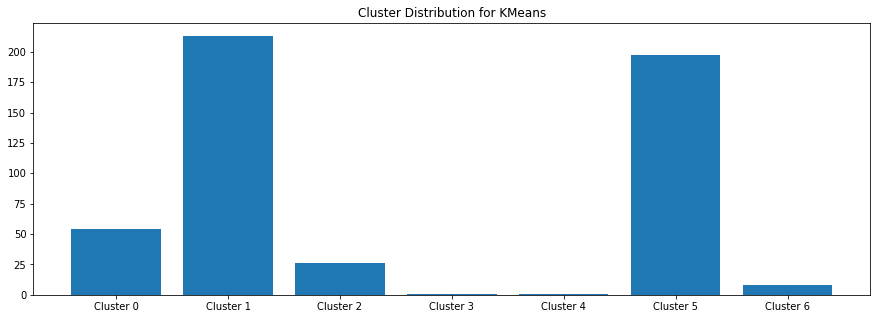

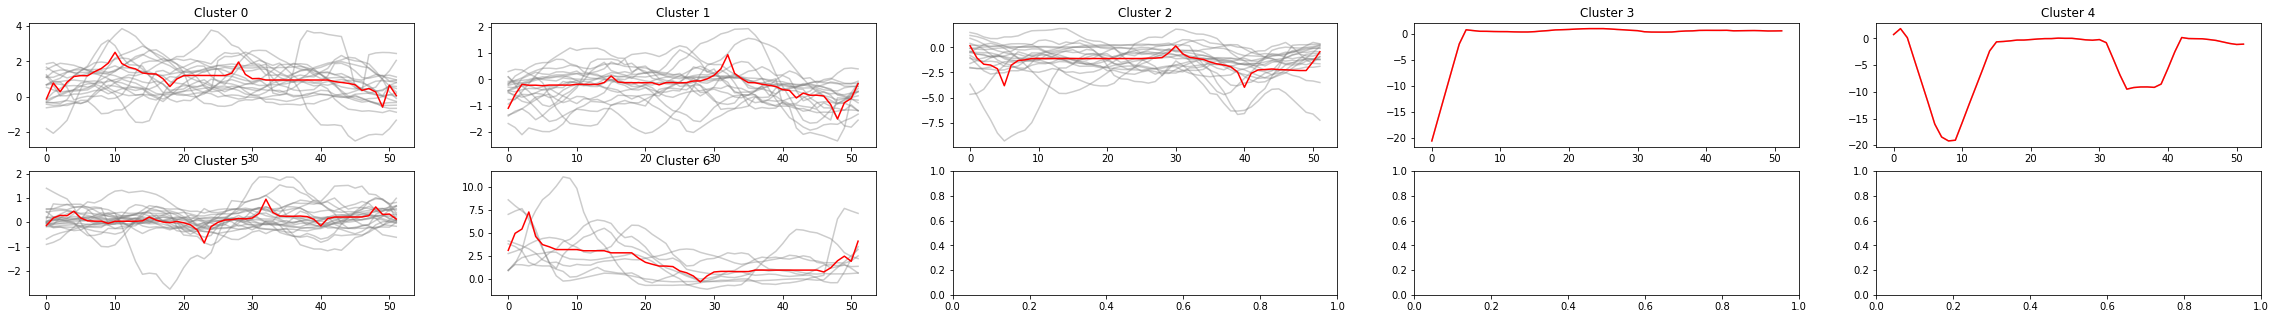

CPU times: user 1min 17s, sys: 2.13 s, total: 1min 19s
Wall time: 1min 21s


In [9]:
%%time
# exmple of a training process
book = preprocess_all_stocks(n_stock=5)
book_ts = dataframe_to_ts(data=book, series='volume_imbalance_sma80')
model = TimeSeriesKMeans(n_clusters=7, metric='dtw', random_state=SEED, n_init=3, max_iter=15, init='k-means++').fit(book_ts)
# model = KShape(n_clusters=7, max_iter=100, n_init=3, random_state=SEED, init='random').fit(book_ts)
plot_cluster_distribution(model=model)
visualize_patterns(model=model, data=book_ts, n_sample_ts=20)

In [10]:
# %%time
# book = preprocess_all_stocks(n_stock=112)
# clust_wap1_sma50 = KShape(n_clusters=7, max_iter=40, n_init=3, random_state=SEED, init='random').fit(dataframe_to_ts(book, 'wap1_sma50'))
# print('Completed Model wap1_sma50')
# clust_wap1_sms50 = KShape(n_clusters=7, max_iter=40, n_init=3, random_state=SEED, init='random').fit(dataframe_to_ts(book, 'wap1_sms50'))
# print('Completed Model wap1_sms50')
# clust_total_volume_sma60 = KShape(n_clusters=7, max_iter=15, n_init=3, random_state=SEED, init='random').fit(dataframe_to_ts(book, 'total_volume_sma60'))
# print('Completed Model total_volume_sma60')
# clust_volume_imbalance_sma80 = KShape(n_clusters=7, max_iter=15, n_init=3, random_state=SEED, init='random').fit(dataframe_to_ts(book, 'volume_imbalance_sma80'))
# print('Completed Model volume_imbalance_sma80')

In [11]:
%%time
book = preprocess_all_stocks(n_stock=112)
clust_wap1_sma50 = TimeSeriesKMeans(n_clusters=7, metric='dtw', random_state=SEED, n_init=5, max_iter=40, init='k-means++').fit(dataframe_to_ts(book, 'wap1_sma50'))
print('Completed Model 1')
clust_wap1_sms50 = TimeSeriesKMeans(n_clusters=7, metric='dtw', random_state=SEED, n_init=5, max_iter=40, init='k-means++').fit(dataframe_to_ts(book, 'wap1_sms50'))
print('Completed Model 2')
clust_total_volume_sma60 = TimeSeriesKMeans(n_clusters=7, metric='dtw', random_state=SEED, n_init=3, max_iter=15, init='k-means++').fit(dataframe_to_ts(book, 'total_volume_sma60'))
print('Completed Model 3')
clust_volume_imbalance_sma80 = TimeSeriesKMeans(n_clusters=7, metric='dtw', random_state=SEED, n_init=3, max_iter=15, init='k-means++').fit(dataframe_to_ts(book, 'volume_imbalance_sma80'))
print('Completed Model 4')

Completed Model 1
Completed Model 2
Completed Model 3
Completed Model 4
CPU times: user 3h 54min 25s, sys: 4min 5s, total: 3h 58min 31s
Wall time: 3h 58min 54s


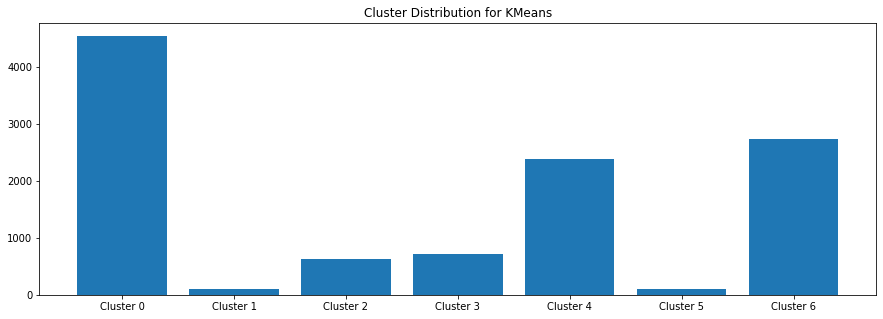

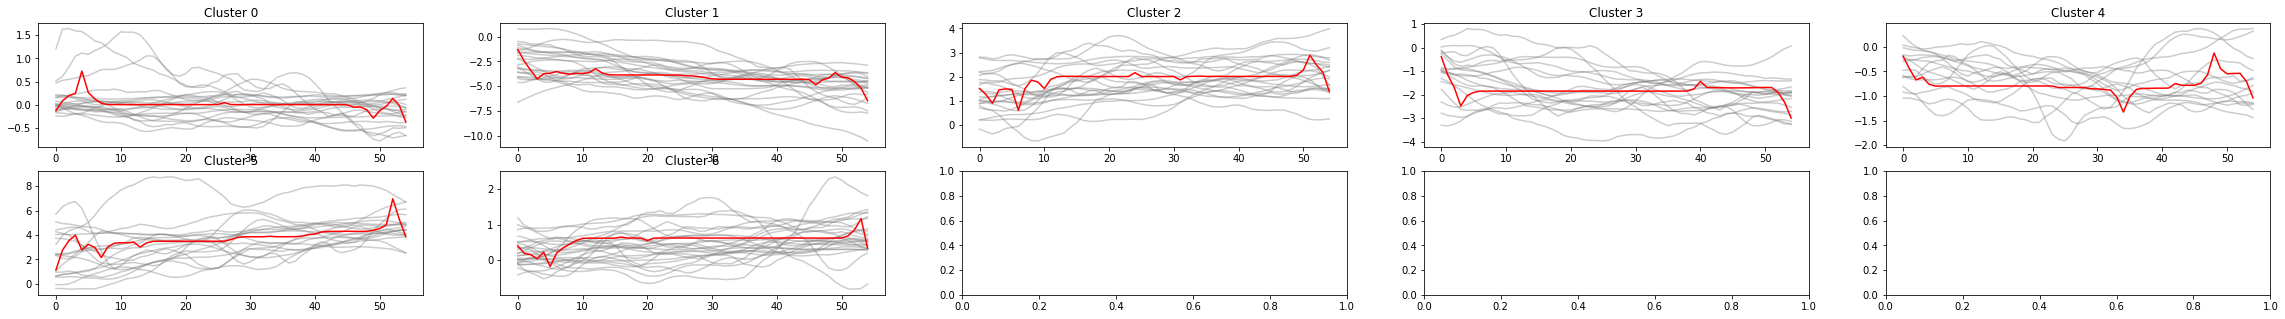

In [12]:
plot_cluster_distribution(model=clust_wap1_sma50)
visualize_patterns(model=clust_wap1_sma50, data=dataframe_to_ts(book, 'wap1_sma50'), n_sample_ts=20)

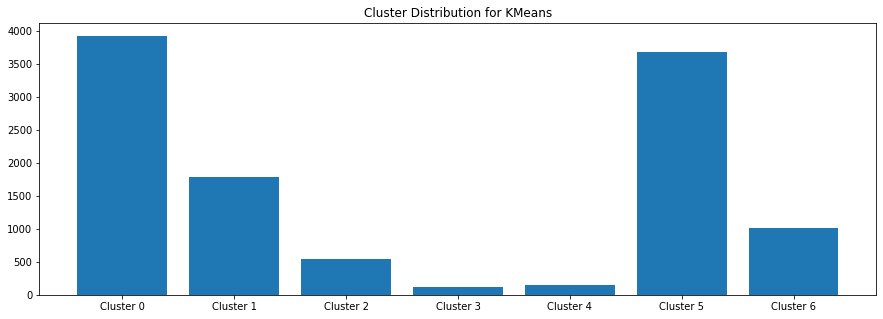

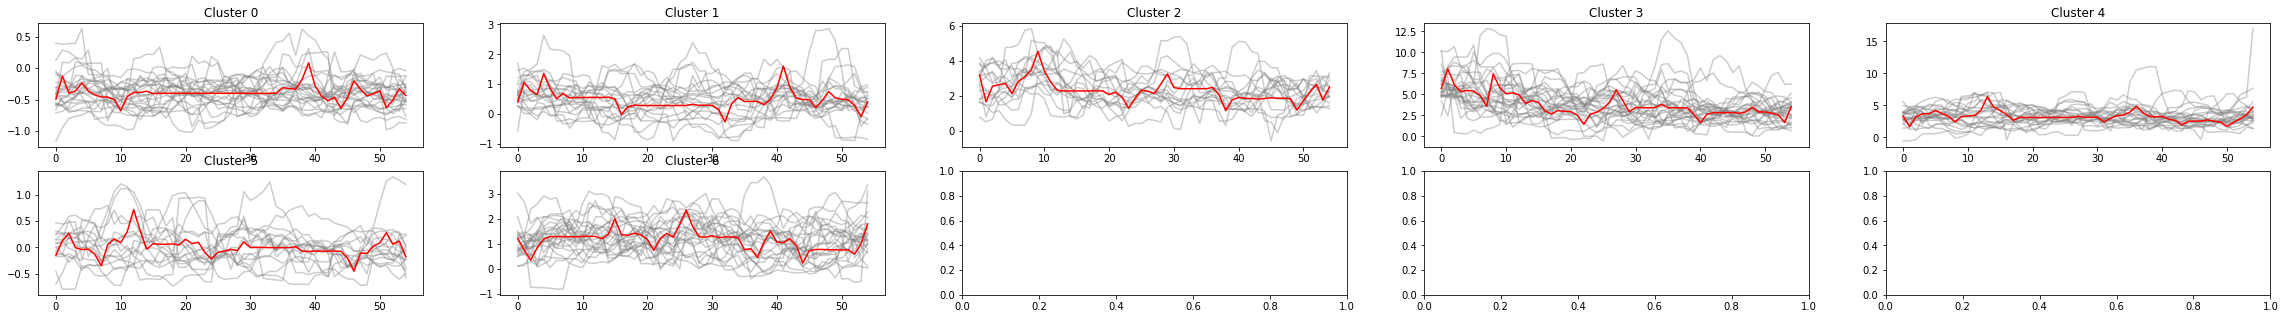

In [13]:
plot_cluster_distribution(model=clust_wap1_sms50)
visualize_patterns(model=clust_wap1_sms50, data=dataframe_to_ts(book, 'wap1_sms50'), n_sample_ts=20)

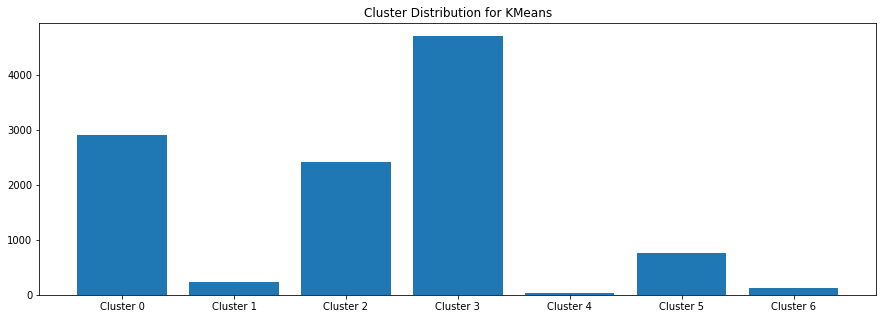

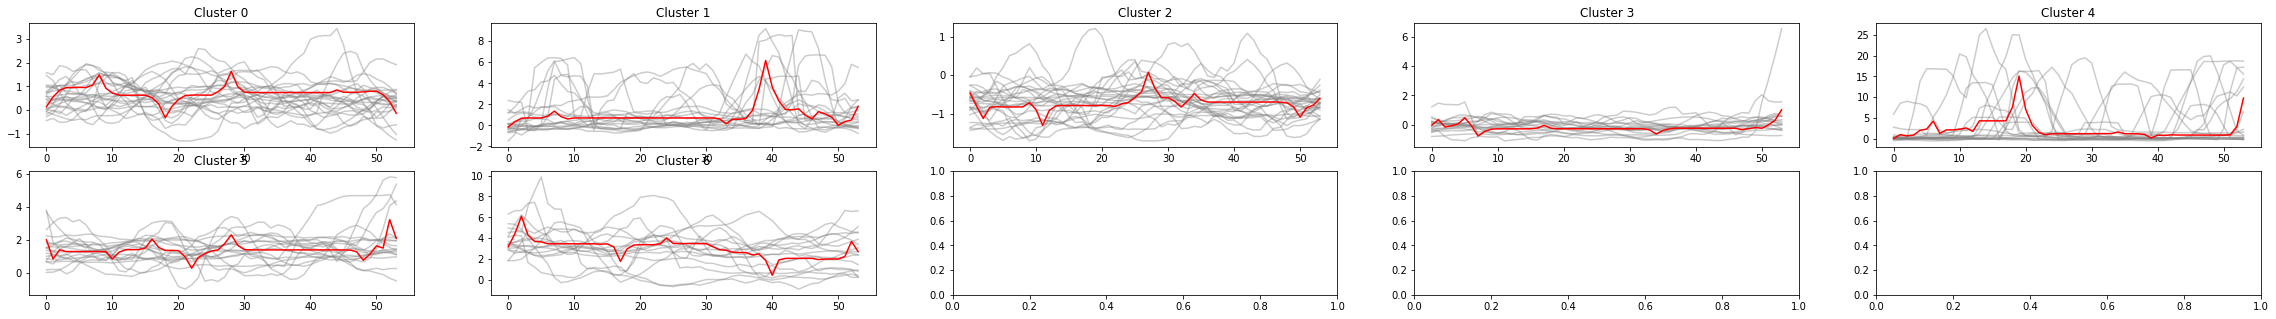

In [14]:
plot_cluster_distribution(model=clust_total_volume_sma60)
visualize_patterns(model=clust_total_volume_sma60, data=dataframe_to_ts(book, 'total_volume_sma60'), n_sample_ts=20)

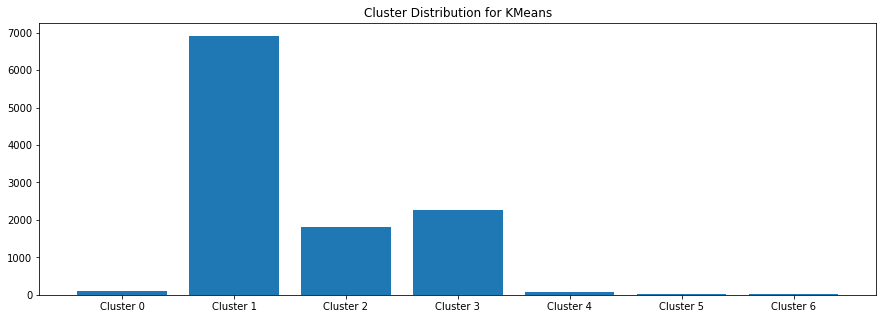

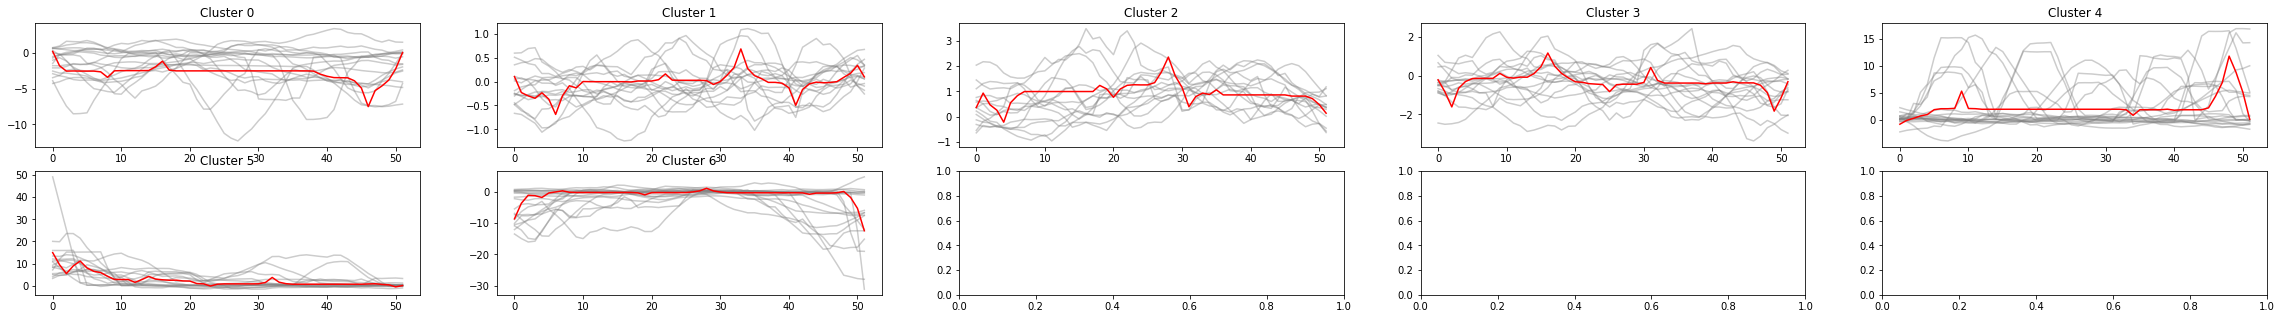

In [15]:
plot_cluster_distribution(model=clust_volume_imbalance_sma80)
visualize_patterns(model=clust_volume_imbalance_sma80, data=dataframe_to_ts(book, 'volume_imbalance_sma80'), n_sample_ts=20)

In [16]:
clust_wap1_sma50.to_pickle('clust_wap1_sma50.p')
clust_wap1_sms50.to_pickle('clust_wap1_sms50.p')
clust_total_volume_sma60.to_pickle('clust_total_volume_sma60.p')
clust_volume_imbalance_sma80.to_pickle('clust_volume_imbalance_sma80.p')

# Making prediction for all training data

In [17]:
%%time
'''
Adding features for Time Series shape clustering
'''
!pip install ../input/tslearn052/tslearn-0.5.2-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl
from tslearn.clustering import TimeSeriesKMeans, KShape
from tslearn.generators import random_walks
from tslearn.utils import to_time_series_dataset
from tslearn.barycenters import dtw_barycenter_averaging
import math
import random

def preprocess_single_stock(stock_id, train_test, n_time_id_sample, seconds_sample_interval, remove_first_n_seconds, delete_unused_cols):
    # load data
    book = load_single_stock(stock_id, train_test, 'book')
    # ffill and bfill
    time_id_list =  pd.DataFrame({'time_id':book.time_id.unique().tolist()})
    seconds_in_bucket_list = pd.DataFrame({'seconds_in_bucket':range(600)})
    base = time_id_list.merge(seconds_in_bucket_list, how='cross')
    book = base.merge(book, how='left', on=['time_id','seconds_in_bucket'])
    book = book.ffill().bfill()
    # sampling time_id
    if n_time_id_sample >= 0:
        time_id_samples = random.sample(book['time_id'].unique().tolist(), n_time_id_sample)
        book = book[book.time_id.isin(time_id_samples)]
    # create time series
    book['wap1'] = (book['bid_price1'] * book['ask_size1'] + book['ask_price1'] * book['bid_size1']) / ( book['bid_size1'] +  book['ask_size1'])
    book['wap1_sma50'] = book.groupby('time_id')['wap1'].apply(lambda s: s.rolling(window=50).mean())
    book['wap1_lr'] = np.log(book['wap1']).diff()
    book['wap1_sms50'] = book.groupby('time_id')['wap1_lr'].apply(lambda s: s.rolling(window=50).std())
    book['total_volume'] = book['ask_size1'] + book['ask_size2'] + book['bid_size1'] + book['bid_size2']
    book['total_volume'] = (book['total_volume'] - book['total_volume'].mean()) / book['total_volume'].std()
    book['total_volume_sma60'] = book.groupby('time_id')['total_volume'].apply(lambda s: s.rolling(window=60).mean())
    book['volume_imbalance'] = (book['ask_size1'] + book['ask_size2']) - (book['bid_size1'] + book['bid_size2'])
    book['volume_imbalance'] = (book['volume_imbalance'] - book['volume_imbalance'].mean()) / book['volume_imbalance'].std()
    book['volume_imbalance_sma80'] = book.groupby('time_id')['volume_imbalance'].apply(lambda s: s.rolling(window=80).mean())
    # remove first few entries to avoid NA
    book = book[book.seconds_in_bucket >= remove_first_n_seconds].reset_index(drop=True)
    # normalization
    book['wap1_sma50'] = (book['wap1_sma50'] - book['wap1_sma50'].mean()) / book['wap1_sma50'].std()
    book['wap1_sms50'] = (book['wap1_sms50'] - book['wap1_sms50'].mean()) / book['wap1_sms50'].std()
    book['total_volume_sma60'] = (book['total_volume_sma60'] - book['total_volume_sma60'].mean()) / book['total_volume_sma60'].std()
    book['volume_imbalance_sma80'] = (book['volume_imbalance_sma80'] - book['volume_imbalance_sma80'].mean()) / book['volume_imbalance_sma80'].std()
    # centering
    book['wap1_sma50'] = book['wap1_sma50'] - book['wap1_sma50'].median()
    book['wap1_sms50'] = book['wap1_sms50'] - book['wap1_sms50'].median()
    book['total_volume_sma60'] = book['total_volume_sma60'] - book['total_volume_sma60'].median()
    book['volume_imbalance_sma80'] = book['volume_imbalance_sma80'] - book['volume_imbalance_sma80'].median()
    # seconds interval filtering
    idx = book.index.tolist()[::seconds_sample_interval]
    book = book.iloc[idx,:]
    # select only relevant columns
    book['stock_id'] = stock_id
    if delete_unused_cols==True:
        book = book[['stock_id','time_id','seconds_in_bucket','wap1_sma50','wap1_sms50','total_volume_sma60','volume_imbalance_sma80']]
    return book

def preprocess_all_stocks(n_stock, train_test, n_time_id_sample, seconds_sample_interval, remove_first_n_seconds, delete_unused_cols):
    stock_list = sorted([int(x.split('=')[1]) for x in os.listdir(f'/kaggle/input/optiver-realized-volatility-prediction/book_{train_test}.parquet')])[:n_stock]
    all_stocks_tagging = []
    for stock_id in stock_list:
        ts = preprocess_single_stock(stock_id=stock_id, train_test=train_test, n_time_id_sample=n_time_id_sample, 
                                     seconds_sample_interval=seconds_sample_interval, remove_first_n_seconds=remove_first_n_seconds, 
                                     delete_unused_cols=delete_unused_cols)
        tagging = ts[['stock_id','time_id']].drop_duplicates()
        path = '/kaggle/working'
        clust_models = ['clust_wap1_sma50','clust_wap1_sms50','clust_total_volume_sma60','clust_volume_imbalance_sma80']
        for name in clust_models[:4]: # loop through models to perform tagging
            model = TimeSeriesKMeans.from_pickle(os.path.join(path, f'{name}.p'))
#             model = KShape.from_pickle(os.path.join(path, f'{name}.p'))
            tagging[name] = model.predict(dataframe_to_ts(data=ts, series=name.replace('clust_','')))
            tagging[name] = tagging[name].astype(int)
        all_stocks_tagging.append(tagging)
        print(f'[{datetime.datetime.now()}] Completed tagging for stock {stock_id}')
    all_stocks_tagging = pd.concat(all_stocks_tagging, axis=0).reset_index(drop=True)
    return all_stocks_tagging


def dataframe_to_ts(data, series):
    ts = [data[(data.stock_id==stock_id) & (data.time_id==time_id) & (data[series].isnull()==False)][series].tolist() for stock_id, time_id in data[['stock_id','time_id']].drop_duplicates().to_records(index=False).tolist()]
    ts = to_time_series_dataset(ts)
    return ts

# create the new features
tagging_train = preprocess_all_stocks(n_stock=112, train_test='train', n_time_id_sample=-1, seconds_sample_interval=10, remove_first_n_seconds=10, delete_unused_cols=True)
tagging_train.to_csv('tagging_train.csv', index=False)

Processing /kaggle/input/tslearn052/tslearn-0.5.2-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl
tslearn is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
[2021-09-09 14:26:07.867988] Completed tagging for stock 0
[2021-09-09 14:27:02.577848] Completed tagging for stock 1
[2021-09-09 14:27:57.317279] Completed tagging for stock 2
[2021-09-09 14:28:52.176015] Completed tagging for stock 3
[2021-09-09 14:29:47.023092] Completed tagging for stock 4
[2021-09-09 14:30:42.021786] Completed tagging for stock 5
[2021-09-09 14:31:37.232961] Completed tagging for stock 6
[2021-09-09 14:32:32.178314] Completed tagging for stock 7
[2021-09-09 14:33:27.838737] Completed tagging for stock 8
[2021-09-09 14:34:22.578890] Completed tagging for stock 9
[2021-09-09 14:35:19.240284] Completed tagging for stock 10
[2021-09-09 14:36:14.481522] Completed tagging for stock 11
[2021-09